# Cartpole System Training

In [1]:
import gym
import numpy as np
import tensorflow as tf
import pickle
import os
from os import path

In [2]:
TOTAL_STEPS = 5000
TRAINING_STEPS = 4000
BATCH_SIZE = 64

## Cartpole-v1 Info
### Action Space
    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
    
### Observation Space
    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8                 | 4.8                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    
### The episode terminates if any one of the following occurs:
    1. Pole Angle is greater than ±12°
    2. Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Episode length is greater than 500 (200 for v0)

(https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

In [3]:
env = gym.make('CartPole-v1')
X = np.empty((TOTAL_STEPS, 4)) # len(env.observation_space.sample()) == 4
U = np.empty((TOTAL_STEPS, 1))
y = np.empty((TOTAL_STEPS, 4))

In [4]:
tf.random.set_seed(1)
np.random.seed(1)

## Sample Trajectories

Controller input $u$ is set as a binary choice of (-1, 1) for (left, right)

In [5]:
x_present = env.reset()
for num_timestep in range(TOTAL_STEPS):
    u = env.action_space.sample() # sidenote: should this be one-hot encoded?
    x_prime, _, done, _ = env.step(u)

    # sample x[n], u[n], and x[n+1]
    if u == 0:
        u = -1
    X[num_timestep] = x_present
    U[num_timestep] = u
    y[num_timestep] = x_prime
    x_present = x_prime
    if done:
        x_present = env.reset()
env.close()

In [6]:
#### "Let-it-run method" ####
# for iteration in range(TOTAL_STEPS // 500):
#     x_present = env.reset()
#     for timestep in range(500):
#         u = env.action_space.sample()
#         x_prime, _, done, _ = env.step(u)

#         # sample x[n], u[n], and x[n+1]
#         if u == 0:
#             u = -1
#         X[500 * iteration + timestep] = x_present
#         U[500 * iteration + timestep] = u
#         y[500 * iteration + timestep] = x_prime
#         x_present = x_prime
# env.close()

## Tensorflow Dataset

In [7]:
if not path.exists('./cartpole_system_model'):
  os.mkdir('./cartpole_system_model')

In [8]:
# create tensorflow dataset object instance; concat X and y
dataset_xu = tf.data.Dataset.from_tensor_slices((X, U))
dataset_y = tf.data.Dataset.from_tensor_slices(y)
dataset = tf.data.Dataset.zip((dataset_xu, dataset_y)).shuffle(500, reshuffle_each_iteration = False)
print(dataset)
# split trajectories into training and testing (no validation)
dataset_training = dataset.take(TRAINING_STEPS)
dataset_testing = dataset.skip(TRAINING_STEPS)
# split training data into batches
dataset_training = dataset_training.repeat(5).batch(BATCH_SIZE)
print(dataset_training)
print(dataset_testing)

<ShuffleDataset shapes: (((4,), (1,)), (4,)), types: ((tf.float64, tf.float64), tf.float64)>
<BatchDataset shapes: (((None, 4), (None, 1)), (None, 4)), types: ((tf.float64, tf.float64), tf.float64)>
<SkipDataset shapes: (((4,), (1,)), (4,)), types: ((tf.float64, tf.float64), tf.float64)>


2022-04-06 15:15:31.964632: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# ShuffleDataset inner workings
print(dataset)
print(dataset.as_numpy_iterator())
for x, i in dataset.as_numpy_iterator():
    print("X and U Sample")
    print(x[0])
    print(x[1])
    print("X Prime Sample")
    print(i)
    break

<ShuffleDataset shapes: (((4,), (1,)), (4,)), types: ((tf.float64, tf.float64), tf.float64)>
X and U Sample
[-0.03037817 -0.95691925  0.08858451  1.505216  ]
[-1.]
X Prime Sample
[-0.04951655 -1.15299714  0.11868882  1.82418942]


In [10]:
# BatchDataset / TakeDataset inner workings
print(dataset_training)
for x, i in dataset_training.as_numpy_iterator():
    print("Batch Size: ", len(x[0]))
    print("X and U Sample")
    print(x[0][0], x[1][0])
    print("X Prime Sample")
    print(i[0])
    break

<BatchDataset shapes: (((None, 4), (None, 1)), (None, 4)), types: ((tf.float64, tf.float64), tf.float64)>
Batch Size:  64
X and U Sample
[-0.03037817 -0.95691925  0.08858451  1.505216  ] [-1.]
X Prime Sample
[-0.04951655 -1.15299714  0.11868882  1.82418942]


In [11]:
# SkipDataset inner workings
print(dataset_testing)
for x, i in dataset_testing.as_numpy_iterator():
    print("Repetition: ", len(x[0]))
    print("X and U Sample")
    print(x[0], x[1])
    print("X Prime Sample")
    print(i)
    break

<SkipDataset shapes: (((4,), (1,)), (4,)), types: ((tf.float64, tf.float64), tf.float64)>
Repetition:  4
X and U Sample
[-0.0447046  -0.4024325   0.02956655  0.61842859] [1.]
X Prime Sample
[-0.05275325 -0.20773576  0.04193512  0.3352024 ]


In [12]:
# tf.data.experimental.save() and load() are deprecated and buggy with Tensorflow 2.
# tf.data.experimental.save(dataset_training, './cartpole_system_model/dataset_training')
# tf.data.experimental.save(dataset_testing, './cartpole_system_model/dataset_testing')
# tf.data.experimental.save(dataset, './cartpole_system_model/dataset')

## Model Definition and Training

In [13]:
class CartpoleLinearControlSystem(tf.keras.Model):
    def __init__(self):
        super(CartpoleLinearControlSystem, self).__init__()
        self.A = tf.keras.layers.Dense(4, input_shape = (4, ), 
                                       activation = 'linear', 
                                       use_bias = False, # Dense is meant to be used as NN layer
                                       name = 'A')
        
        self.B = tf.keras.layers.Dense(4, input_shape = (1, ), 
                                       activation = 'linear', 
                                       use_bias = False, 
                                       name = 'B')
        
        self.add = tf.keras.layers.Add()
        
    def call(self, inputs):
        x, u = inputs
        return self.A(x) + self.B(u)

Uses reference code in *Python Machine Learning: 3rd Edition* (Raschka and Mirjalili, 2019) pp. 438, 512-515

In [14]:
# compile model
model = CartpoleLinearControlSystem()
model.compile(tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.MeanSquaredError()])
history = model.fit(dataset_training, epochs = 200)
tf.keras.models.save_model(
    model, './cartpole_system_model', overwrite = True, include_optimizer = True, save_format = None,
    signatures = None, options = None, save_traces = True
)

Epoch 1/200
313/313 [==============================] - 1s 2ms/step - loss: 0.5883 - mean_squared_error: 0.5883
Epoch 2/200
313/313 [==============================] - 0s 1ms/step - loss: 0.2570 - mean_squared_error: 0.2570
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1075 - mean_squared_error: 0.1075
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0450 - mean_squared_error: 0.0450
Epoch 5/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 6/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 7/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 9/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
E

313/313 [==============================] - 0s 1ms/step - loss: 8.9718e-07 - mean_squared_error: 8.9718e-07
Epoch 71/200
313/313 [==============================] - 0s 1ms/step - loss: 9.0704e-07 - mean_squared_error: 9.0704e-07
Epoch 72/200
313/313 [==============================] - 0s 1ms/step - loss: 9.0949e-07 - mean_squared_error: 9.0949e-07
Epoch 73/200
313/313 [==============================] - 0s 1ms/step - loss: 8.9704e-07 - mean_squared_error: 8.9704e-07
Epoch 74/200
313/313 [==============================] - 0s 1ms/step - loss: 8.9705e-07 - mean_squared_error: 8.9705e-07
Epoch 75/200
313/313 [==============================] - 1s 2ms/step - loss: 9.0028e-07 - mean_squared_error: 9.0028e-07
Epoch 76/200
313/313 [==============================] - 0s 1ms/step - loss: 9.0510e-07 - mean_squared_error: 9.0510e-07
Epoch 77/200
313/313 [==============================] - 0s 1ms/step - loss: 8.9708e-07 - mean_squared_error: 8.9708e-07
Epoch 78/200
313/313 [==============================]

313/313 [==============================] - 0s 1ms/step - loss: 8.9705e-07 - mean_squared_error: 8.9705e-07
Epoch 139/200
313/313 [==============================] - 0s 2ms/step - loss: 9.0708e-07 - mean_squared_error: 9.0708e-07
Epoch 140/200
313/313 [==============================] - 1s 2ms/step - loss: 8.9711e-07 - mean_squared_error: 8.9711e-07
Epoch 141/200
313/313 [==============================] - 0s 1ms/step - loss: 8.9705e-07 - mean_squared_error: 8.9705e-07
Epoch 142/200
313/313 [==============================] - 0s 1ms/step - loss: 8.9872e-07 - mean_squared_error: 8.9872e-07
Epoch 143/200
313/313 [==============================] - 1s 2ms/step - loss: 9.1411e-07 - mean_squared_error: 9.1411e-07
Epoch 144/200
313/313 [==============================] - 0s 1ms/step - loss: 8.9728e-07 - mean_squared_error: 8.9728e-07
Epoch 145/200
313/313 [==============================] - 0s 1ms/step - loss: 8.9705e-07 - mean_squared_error: 8.9705e-07
Epoch 146/200
313/313 [=======================

2022-04-06 15:17:05.995692: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./cartpole_system_model/assets


/Users/johnlime/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [15]:
with open('./cartpole_system_model/history.pkl', 'wb') as filepath:
    pickle.dump(history, filepath)

INFO:tensorflow:Assets written to: ram://63c95a0c-b254-4c94-b568-e3944db43f46/assets


/Users/johnlime/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Model Evaluation and Learning Curve Visualization

In [16]:
model = tf.keras.models.load_model(
    './cartpole_system_model', custom_objects=None, compile=True, options=None
)

history = None
with open('./cartpole_system_model/history.pkl', 'rb') as filepath:
    history = pickle.load(filepath)
    
history_keys = history.history.keys()

In [17]:
# tf.data.experimental.save() and load() are deprecated and buggy with Tensorflow 2.
# dataset_training = tf.data.experimental.load('./cartpole_system_model/dataset_training')
# dataset_testing = tf.data.experimental.load('./cartpole_system_model/dataset_testing')
# dataset = tf.data.experimental.load('./cartpole_system_model/dataset')

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def show_history(history_obj, y_data_name):
    # plt.plot(range(history_obj.params['epochs']), history_obj.history[y_data_name])
    plt.plot(range(100), history_obj.history[y_data_name][:100])
    plt.xlabel("Epochs")
    plt.ylabel(y_data_name)
    plt.savefig('./cartpole_system_model/' + y_data_name + '.png')
    plt.show()

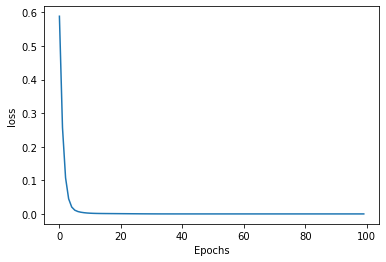

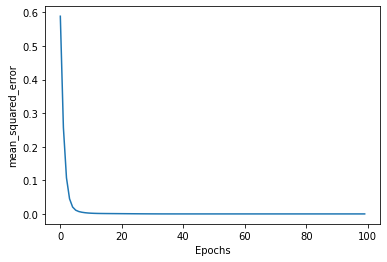

In [20]:
for i, key in enumerate(history.history.keys()):
  show_history(history, key)

In [21]:
model.summary()

Model: "cartpole_linear_control_system"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 A (Dense)                   multiple                  16        
                                                                 
 B (Dense)                   multiple                  4         
                                                                 
 add (Add)                   multiple                  0         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [22]:
prediction_result = model.evaluate(dataset_testing.batch(8))
print(prediction_result)

125/125 [==============================] - 0s 877us/step - loss: 8.4227e-07 - mean_squared_error: 8.4227e-07
[8.4227400520831e-07, 8.4227400520831e-07]
